# Download Daymet

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds) |

Notes:
 - The Daymet calendar is based on a standard calendar year. All Daymet years, including leap years, have 1 - 365 days. For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.
 
 - DayMet's incident shortwave radiation is the "daylit" radiation.  To get the daily average radiation, one must multiply by daylit fraction, given by dayl / 86400.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import logging,yaml
import numpy as np
import rasterio
import fiona
import os

import watershed_workflow
import watershed_workflow.ui
import watershed_workflow.sources.manager_daymet
import watershed_workflow.daymet
import watershed_workflow.io

watershed_workflow.ui.setup_logging(1,None)

In [3]:
watershed_shapefile = '../../data/examples/CoalCreek/sources/shapefile/CoalCreek.shp'
config_fname = '../../data/examples/CoalCreek/processed/config.yaml'

In [4]:
# dates are in YYYY-MM-DD
# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start_date = "2015-10-1"
end_date = "2016-10-1"
origin_date = "1980-1-1"

In [5]:
# Load the dictionary from the file
with open(config_fname, 'r') as file:
    outputs = yaml.load(file, Loader=yaml.FullLoader)

## import watershed

In [6]:
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

bounds = watershed.exterior().bounds
print(bounds)
print(bounds[2] - bounds[0], bounds[3] - bounds[1])

2023-07-11 11:35:57,690 - root - INFO: 
2023-07-11 11:35:57,691 - root - INFO: Loading shapes
2023-07-11 11:35:57,691 - root - INFO: ------------------------------
2023-07-11 11:35:57,691 - root - INFO: Loading file: '../../data/examples/CoalCreek/sources/shapefile/CoalCreek.shp'
2023-07-11 11:35:57,704 - root - INFO: ... found 1 shapes
2023-07-11 11:35:57,705 - root - INFO: Converting to shapely
2023-07-11 11:35:57,708 - root - INFO: crs: epsg:26913


(317251.2640131897, 4299711.408984916, 328473.7039815487, 4307062.45088187)
11222.439968359016 7351.041896954179


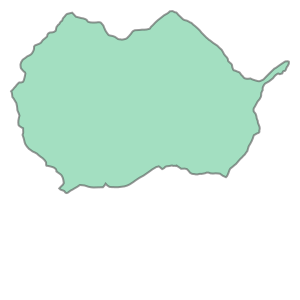

In [7]:
watershed.exterior()

## Download

returned raw data has `dim(nband, ncol, nrow)`

In [8]:
# setting vars = None to download all available variables
source = watershed_workflow.sources.manager_daymet.FileManagerDaymet()
data = source.get_data(bounds, crs, start = start_date, end = end_date)

2023-07-11 11:35:57,723 - root - INFO: Collecting DayMet file to tile bounds: [-107.1172, 38.8172, -106.966, 38.9057]
2023-07-11 11:35:57,724 - root - INFO:   Using existing: /Users/shuai/github/watershed-workflow/data_library/meteorology/daymet/daymet_tmin_2015_38.9057x-107.1172_38.8172x-106.9660.nc
2023-07-11 11:35:57,725 - root - INFO: Collecting DayMet file to tile bounds: [-107.1172, 38.8172, -106.966, 38.9057]
2023-07-11 11:35:57,725 - root - INFO:   Using existing: /Users/shuai/github/watershed-workflow/data_library/meteorology/daymet/daymet_tmin_2016_38.9057x-107.1172_38.8172x-106.9660.nc
2023-07-11 11:35:57,726 - root - INFO: Collecting DayMet file to tile bounds: [-107.1172, 38.8172, -106.966, 38.9057]
2023-07-11 11:35:57,726 - root - INFO:   Using existing: /Users/shuai/github/watershed-workflow/data_library/meteorology/daymet/daymet_tmax_2015_38.9057x-107.1172_38.8172x-106.9660.nc
2023-07-11 11:35:57,727 - root - INFO: Collecting DayMet file to tile bounds: [-107.1172, 38.8

## Reproject Daymet CRS

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS.

In [9]:
data_new = watershed_workflow.warp.state(data, dst_crs=crs)

## plot Daymet

/Users/shuai/mambaforge/envs/watershed_workflow-2023-04-03/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2023-07-11 11:35:58,053 - root - INFO: BOUNDS: (-590250.0, -366000.0, -577250.0, -356000.0)
2023-07-11 11:35:58,060 - root - INFO: BOUNDS: (315801.341583648, 4297539.707055377, 330249.7068281529, 4309098.3992509805)


Text(0.5, 1.0, 'Reprojected Daymet')

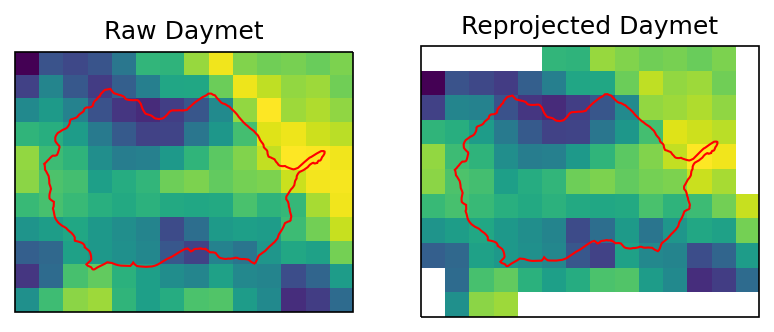

In [10]:
ivar = 'tmax'
islice = 100
daymet_crs = watershed_workflow.crs.daymet_crs()

fig = plt.figure()
ax1 = watershed_workflow.plot.get_ax(daymet_crs, fig, 1, 2, 1)
ax2 = watershed_workflow.plot.get_ax(crs, fig, 1, 2, 2)

watershed_ext_daymet = watershed_workflow.warp.shply(watershed.exterior(),
                                                     crs, daymet_crs)
watershed_workflow.plot.raster(data[ivar].profile, data[ivar].data[islice,:,:], ax1)
watershed_workflow.plot.shply(watershed_ext_daymet, daymet_crs, ax=ax1, color='r')

watershed_workflow.plot.raster(data_new[ivar].profile, data_new[ivar].data[islice,:,:], ax2)
watershed_workflow.plot.hucs(watershed, crs, ax=ax2, color='r')

ax1.set_title("Raw Daymet")
ax2.set_title("Reprojected Daymet")



# save daymet

## Write to HDF5

This will write daymet in a format that ATS can read. E.g., this will calculate mean air temperature, convert units, partition precipitation into rain and snow based on mean temp, and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [11]:
assert(len(data_new.collections) == 1)
met_data = data_new.collections[0]

In [12]:
met_data_ats = watershed_workflow.daymet.daymet_to_daily_averages(met_data)


outputs['daymet_filename'] = os.path.join('..', '..', 'data', 'examples','CoalCreek', 'processed','watershed_daymet.h5')
watershed_workflow.io.write_dataset_to_hdf5(
    filename = outputs['daymet_filename'],
    dataset= met_data_ats.collections[0],
    attributes= watershed_workflow.daymet.getAttributes(bounds, start_date, end_date),
    time0 = origin_date
)
    

2023-07-11 11:35:58,126 - root - INFO: Converting to ATS met input
2023-07-11 11:35:58,129 - root - INFO: Writing HDF5 file: ../../data/examples/CoalCreek/processed/watershed_daymet.h5


In [13]:
outputs

{'LAI_filename': '../../data/examples/CoalCreek/processed/watershed_lai_raw.h5',
 'daymet_filename': '../../data/examples/CoalCreek/processed/watershed_daymet.h5',
 'mesh_filename': '../../data/examples/CoalCreek/processed/watershed_mesh.exo',
 'subsurface_properties_filename': '../../data/examples/CoalCreek/processed/watershed_subsurface_properties.csv'}

In [14]:
with open(config_fname, 'w') as file:
    yaml.dump(outputs, file)